In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 1
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = 2*m
    else:
        dset = prime_test_loss_samples
        leng = 2*(n-m)
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        out_is = out.cpu().detach().numpy().flatten()[0] * pmf * get_x_pmf() * leng * ind
        outs.append(out_is)
        res = np.average(outs)
    return res

def plot_loss(train_loss, test_loss, i, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.title('Loss after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.title('Recall after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.title('CDF after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [8]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [10]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    train_losses = []
    train_recalls = []
    train_recall_outputs = [] 

    test_losses = []
    test_recalls = []
    test_recall_outputs = []

    new_outputs = []
    
    train_correct = 0
    test_correct = 0
    
    for i, ele in enumerate(tqdm.tqdm(train_ds)):
        if i == 0:
            continue
        model.train()
        optim.zero_grad() #reset gradients after update
        x, y = convert(ele[0], ele[1]) #sample x,y from S_train
        out = update(x, y) #get S_train output/score
        log_out = torch.log(out) #take log
        # Calculate train recall
        train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
        if train_score > 0.6:
            train_correct += 1 #contribute to train recall
        train_recall_outputs.append(train_score) #store the train scores
        
        optim.zero_grad() #reset gradients for the second branch
        y_pmf = get_y_pmf(ele[2][1])
        x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
        out_prime = update(x_prime, y_prime) #get score'
        out_prime = out_prime*y_pmf*get_x_pmf()*2*m #adjust for IS
        const = ele[3] #indicator
        (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
        optim.step() #gradient update

        model.eval()
        x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
        test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
        test_recall_outputs.append(test_score) #store the test scores
        if test_score > 0.6:
            test_correct += 1 #contribute to test recall
            
        #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
        for x, y in S_new[10*i:10*(i+1)]:
            x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
            new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
            new_outputs.append(new_score) #store the new unknown scores

        if i % 500 == 0:
            train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
            test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            train_recall = 100*train_correct/i #training recall
            train_recalls.append(train_recall) 
            test_recall = 100*test_correct/i #test recall
            test_recalls.append(test_recall)
            if i > 1000:
                train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
            else:
                train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
            train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
            test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


        if i % 5000 == 0:
            plot_recall(train_recalls, test_recalls, i, lamb, gamma)
            plot_loss(train_losses, test_losses, i, lamb, gamma)
            plot_cdf(train_cdf, test_cdf, i, lamb, gamma)
            print("New score: ", np.average(new_outputs[-20:]))
            print("Train score: ", np.average(train_score[-20:]))
            print("Test score: ", np.average(test_score[-20:]))

## Hyperparameter tuning

In [11]:
gammas = [1e-3]
lambdas = [1e28]

  1%|          | 4998/473047 [14:30<6:08:07, 21.19it/s]   

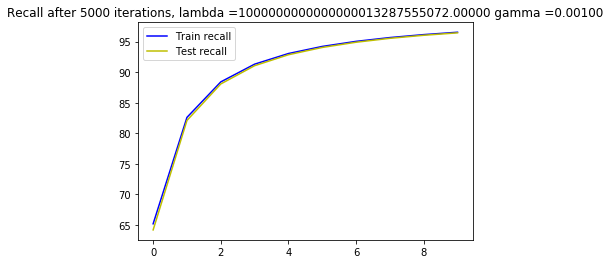

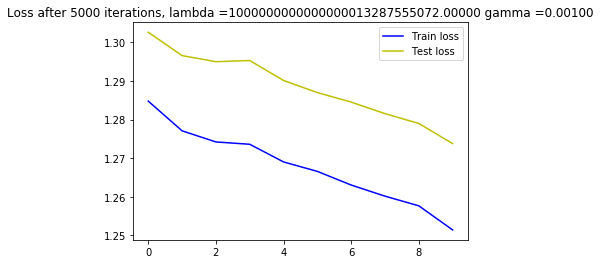

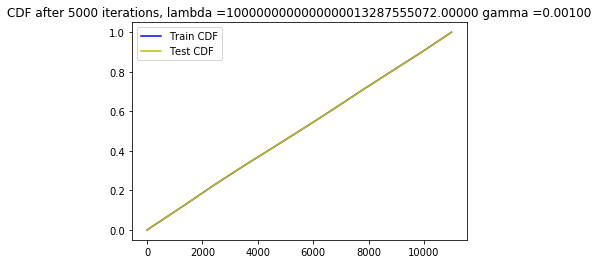

  1%|          | 5002/473047 [15:11<514:59:20,  3.96s/it]

New score:  0.70778084
Train score:  0.7305316
Test score:  0.73341686


  2%|▏         | 9994/473047 [29:20<3:51:41, 33.31it/s]   

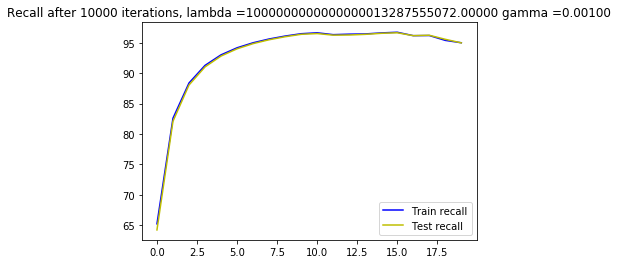

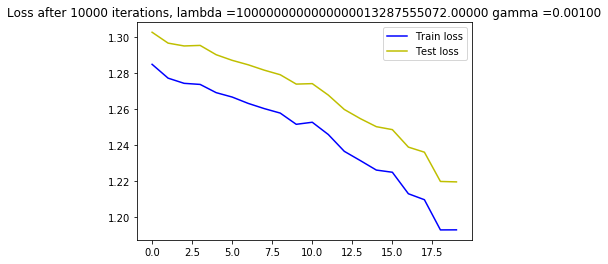

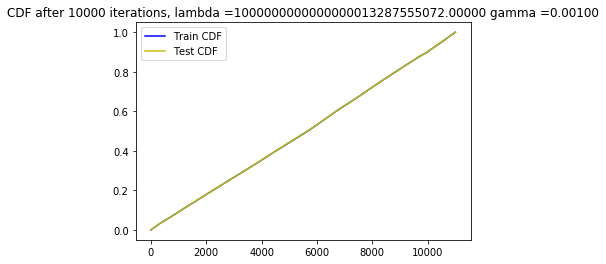

  2%|▏         | 10002/473047 [30:00<224:19:57,  1.74s/it]

New score:  0.52875245
Train score:  0.6010748
Test score:  0.6226911


  3%|▎         | 14994/473047 [33:27<1:22:24, 92.63it/s]   

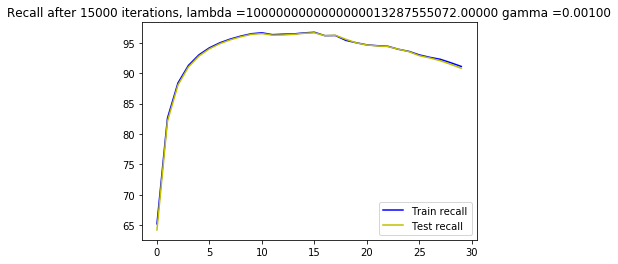

  3%|▎         | 14994/473047 [33:40<1:22:24, 92.63it/s]

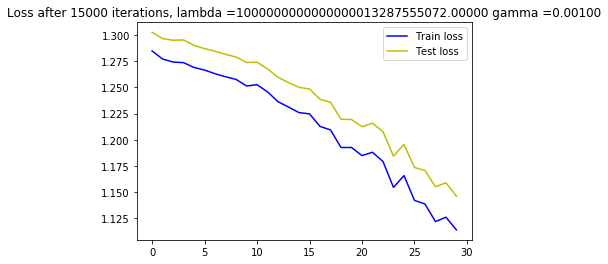

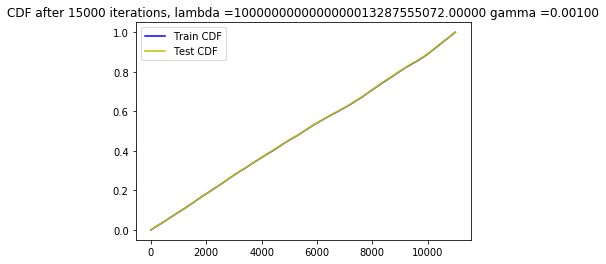

  3%|▎         | 15011/473047 [33:40<50:01:48,  2.54it/s]

New score:  0.7238208
Train score:  0.7202549
Test score:  0.7027135


  4%|▍         | 19999/473047 [36:20<1:33:46, 80.52it/s] 

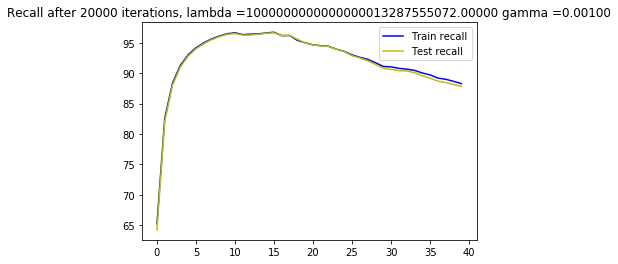

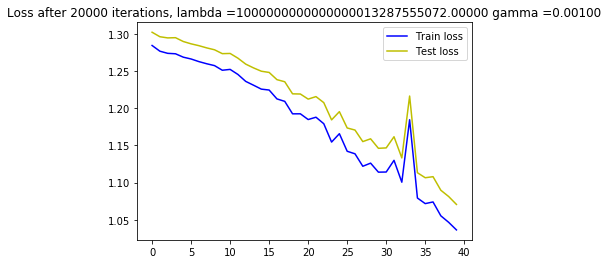

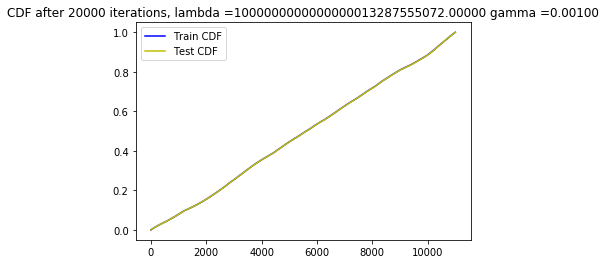

  4%|▍         | 20016/473047 [36:32<35:30:03,  3.54it/s]

New score:  0.5893144
Train score:  0.6660944
Test score:  0.73765486


  5%|▌         | 24994/473047 [39:16<1:33:20, 80.00it/s] 

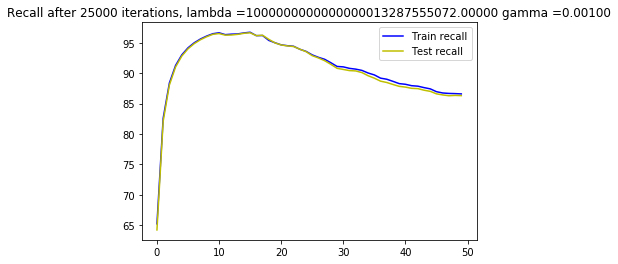

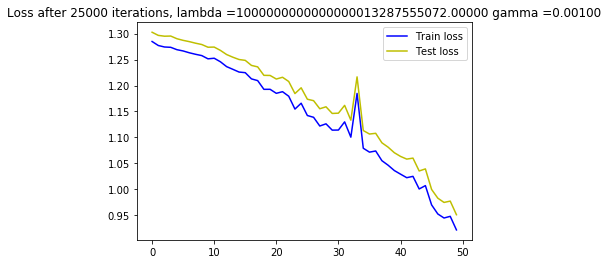

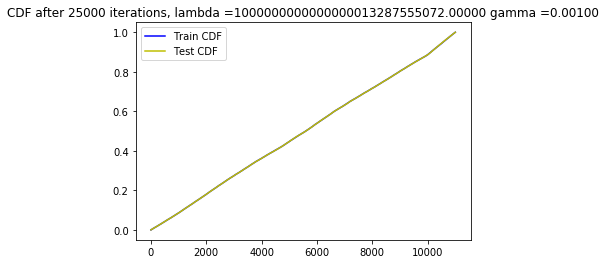

  5%|▌         | 25012/473047 [39:28<35:25:06,  3.51it/s]

New score:  0.5995792
Train score:  0.74671566
Test score:  0.7408375


  6%|▋         | 29992/473047 [42:12<1:32:02, 80.22it/s] 

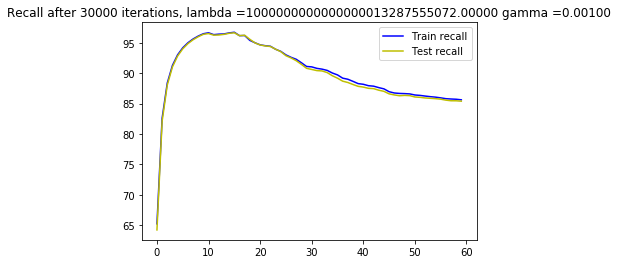

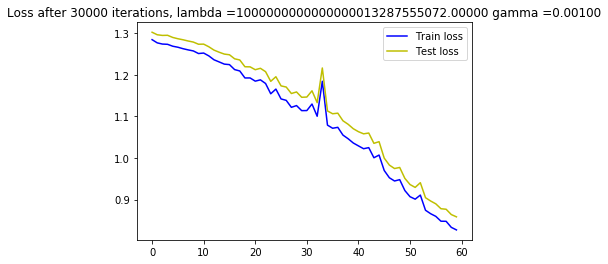

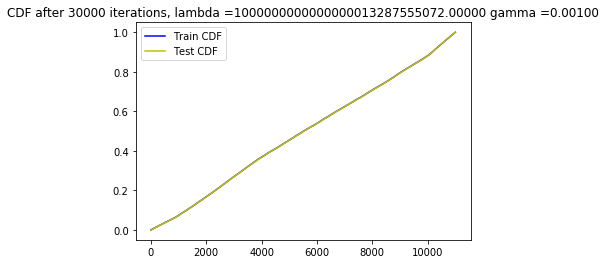

  6%|▋         | 30009/473047 [42:24<35:21:10,  3.48it/s]

New score:  0.6089638
Train score:  0.82160205
Test score:  0.7974473


  7%|▋         | 34995/473047 [45:20<1:31:04, 80.16it/s] 

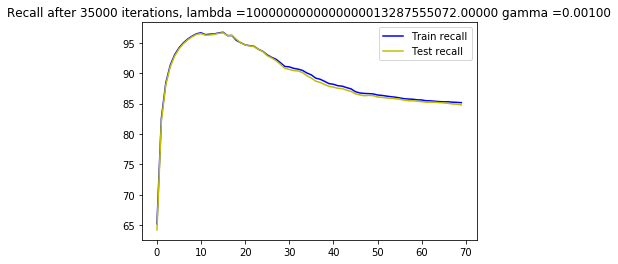

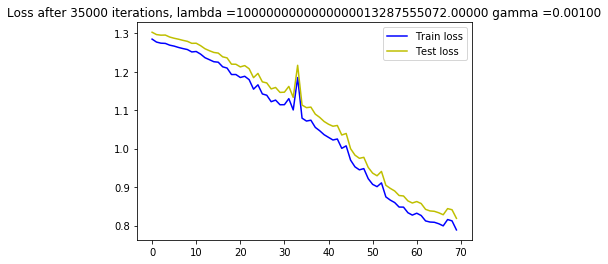

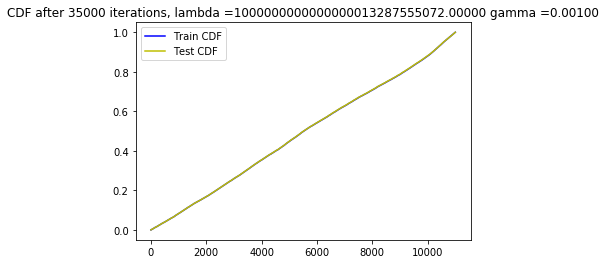

  7%|▋         | 35009/473047 [45:20<51:59:25,  2.34it/s]

New score:  0.60512435
Train score:  0.85009325
Test score:  0.78605676


  8%|▊         | 39994/473047 [48:04<1:31:06, 79.21it/s]  

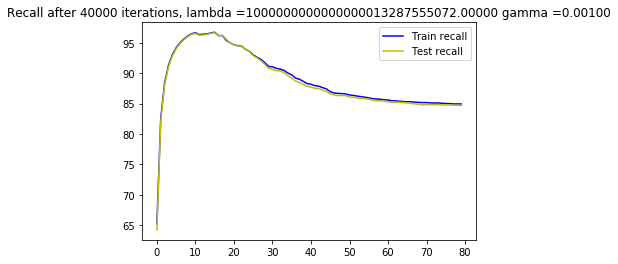

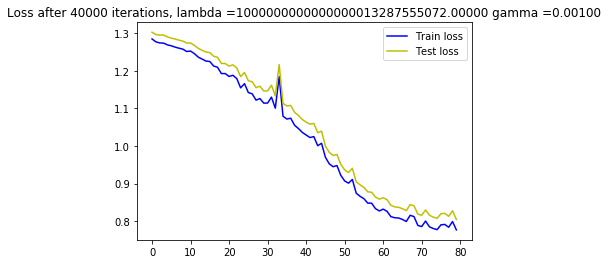

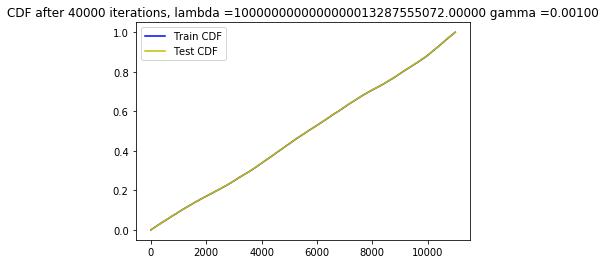

  8%|▊         | 40010/473047 [48:16<38:32:00,  3.12it/s]

New score:  0.60081244
Train score:  0.8401736
Test score:  0.8697382


 10%|▉         | 44994/473047 [51:00<1:29:13, 79.96it/s] 

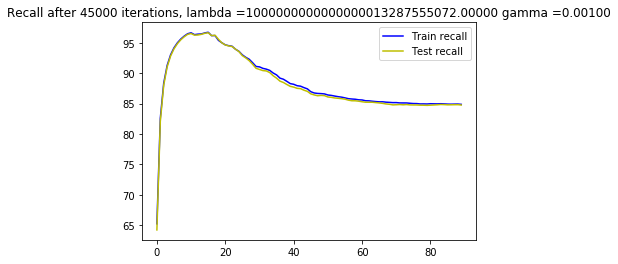

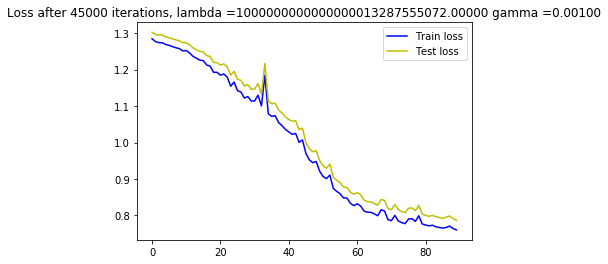

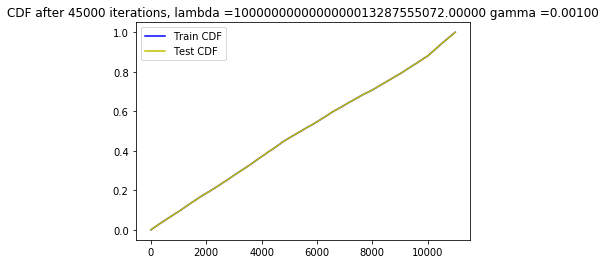

 10%|▉         | 45011/473047 [51:12<37:29:12,  3.17it/s]

New score:  0.73258555
Train score:  0.67640036
Test score:  0.76560843


 11%|█         | 49992/473047 [53:53<1:27:32, 80.55it/s]  

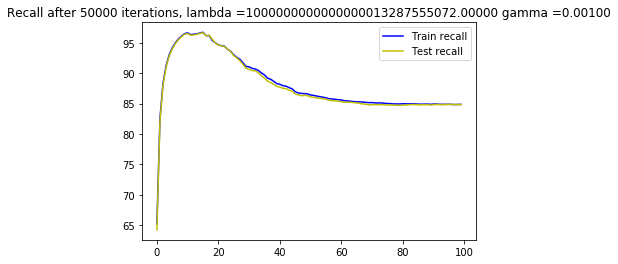

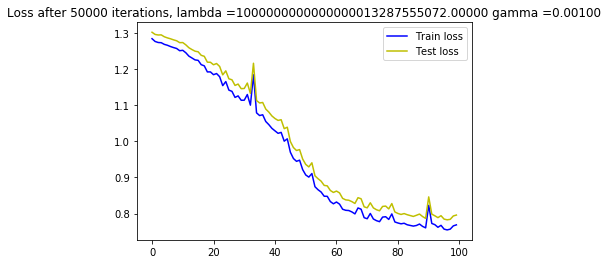

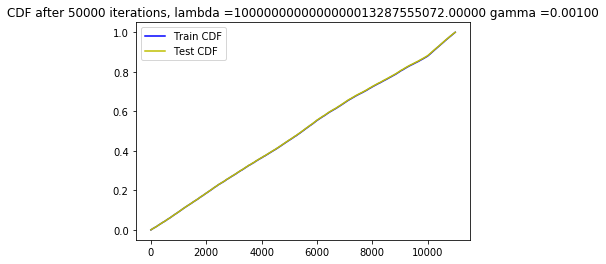

 11%|█         | 50009/473047 [54:05<33:38:14,  3.49it/s]

New score:  0.5341356
Train score:  0.8307856
Test score:  0.8099767


 12%|█▏        | 54994/473047 [57:00<1:27:21, 79.75it/s] 

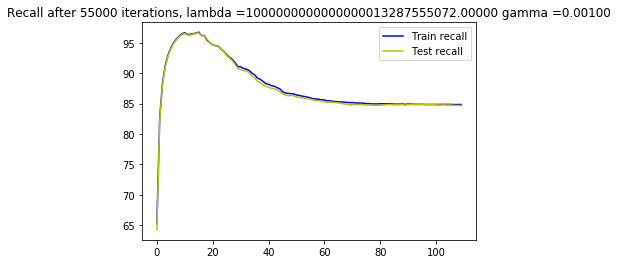

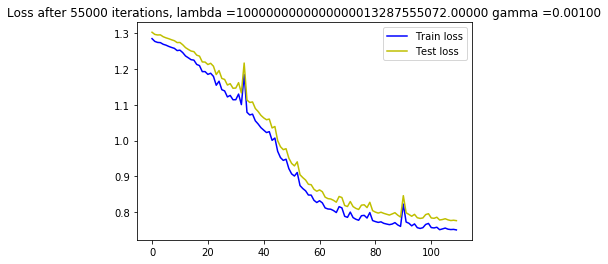

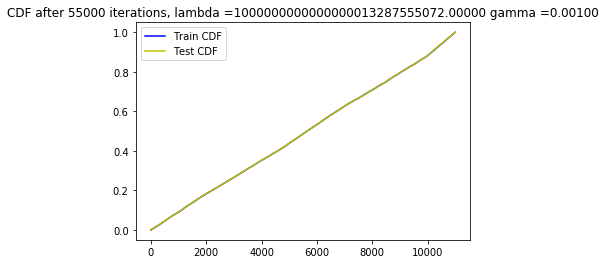

 12%|█▏        | 55009/473047 [57:01<41:06:36,  2.82it/s]

New score:  0.65338373
Train score:  0.90256417
Test score:  0.9182078


 13%|█▎        | 59995/473047 [59:44<1:26:12, 79.85it/s]  

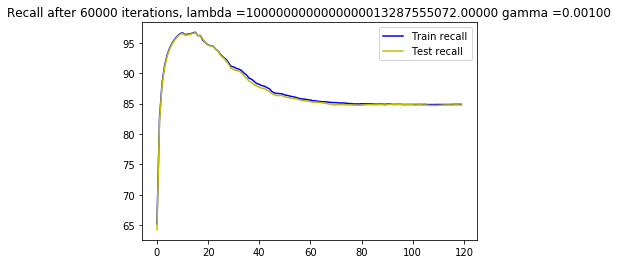

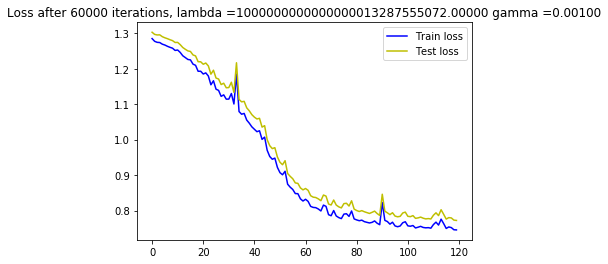

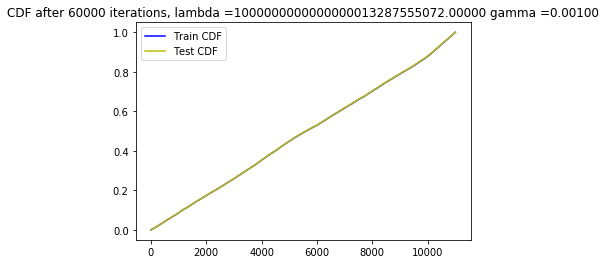

 13%|█▎        | 60011/473047 [59:55<36:34:44,  3.14it/s]

New score:  0.60568786
Train score:  0.8839386
Test score:  0.80288804


 14%|█▎        | 64998/473047 [1:02:50<1:25:27, 79.58it/s]  

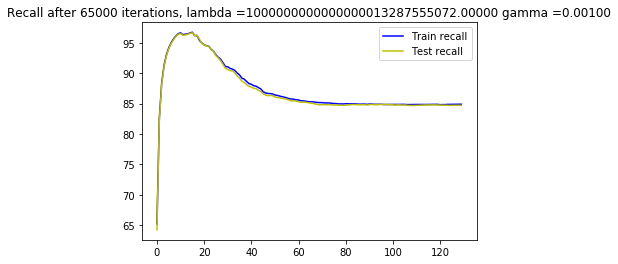

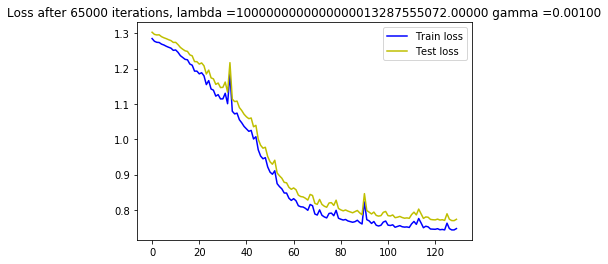

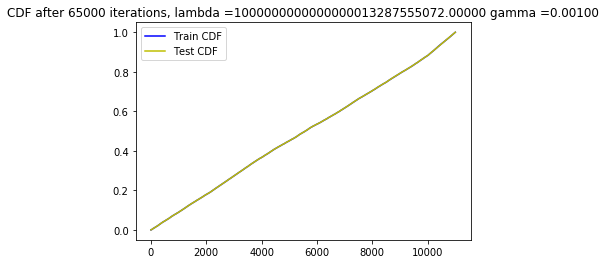

 14%|█▎        | 65009/473047 [1:02:51<94:25:20,  1.20it/s] 

New score:  0.5678197
Train score:  0.8305114
Test score:  0.81883353


 15%|█▍        | 69993/473047 [1:05:34<1:24:11, 79.79it/s]  

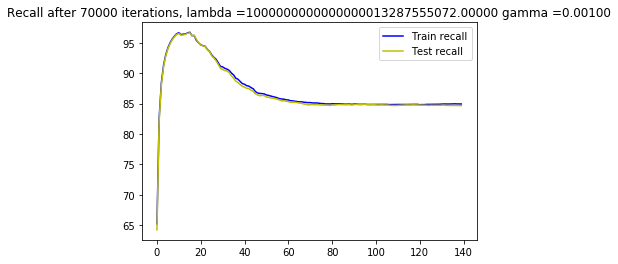

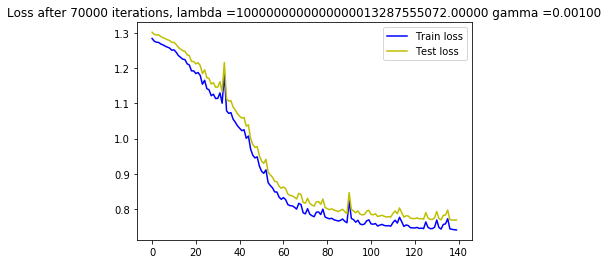

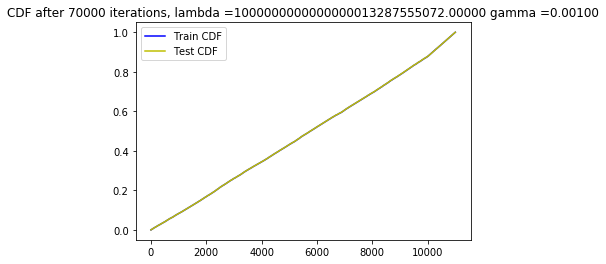

 15%|█▍        | 70009/473047 [1:05:46<35:51:04,  3.12it/s]

New score:  0.4945131
Train score:  0.90195495
Test score:  0.72450614


 16%|█▌        | 74996/473047 [1:08:27<1:13:58, 89.68it/s] 

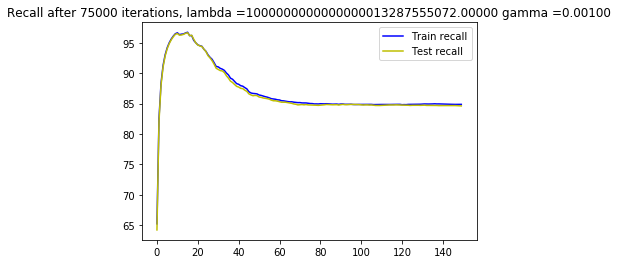

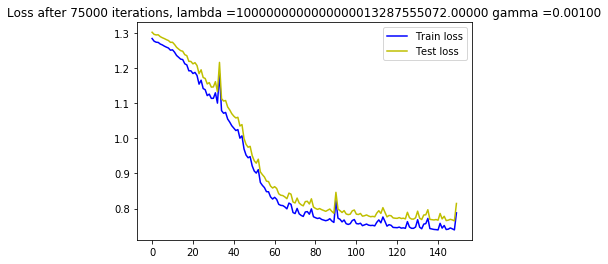

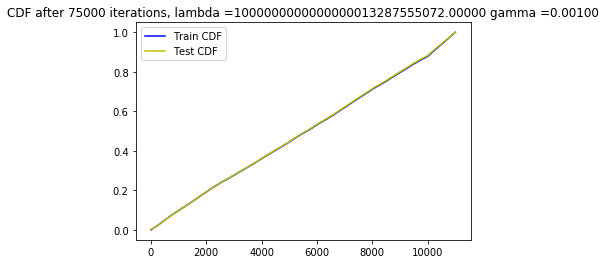

 16%|█▌        | 75014/473047 [1:08:39<32:09:30,  3.44it/s]

New score:  0.5688335
Train score:  0.8295926
Test score:  0.6997658


 17%|█▋        | 79996/473047 [1:11:21<1:21:15, 80.62it/s] 

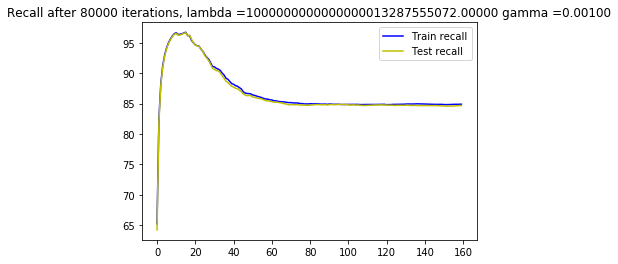

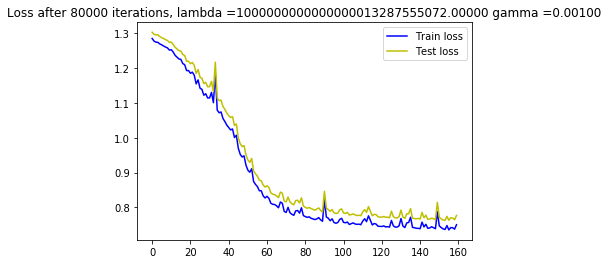

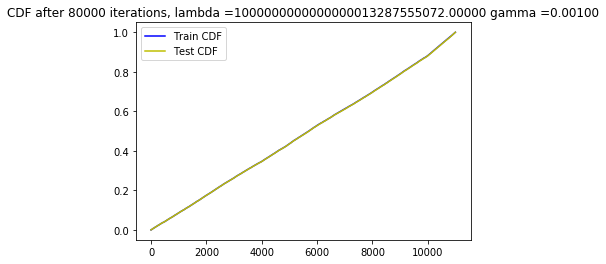

 17%|█▋        | 80014/473047 [1:11:32<30:57:47,  3.53it/s]

New score:  0.65908337
Train score:  0.8548881
Test score:  0.93122464


 18%|█▊        | 84992/473047 [1:14:15<1:19:57, 80.89it/s]  

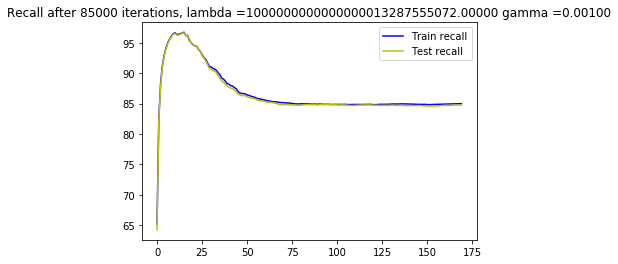

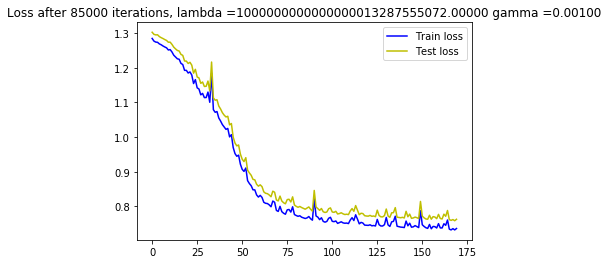

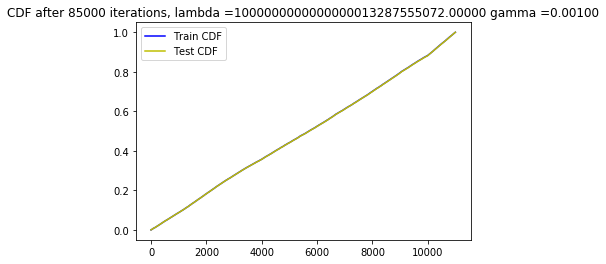

 18%|█▊        | 85009/473047 [1:14:27<30:15:41,  3.56it/s]

New score:  0.49971575
Train score:  0.76251334
Test score:  0.80468875


 19%|█▉        | 89993/473047 [1:17:20<1:19:04, 80.73it/s] 

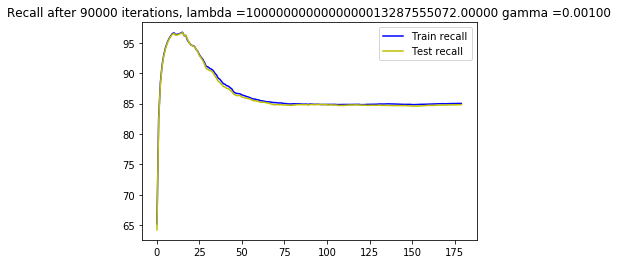

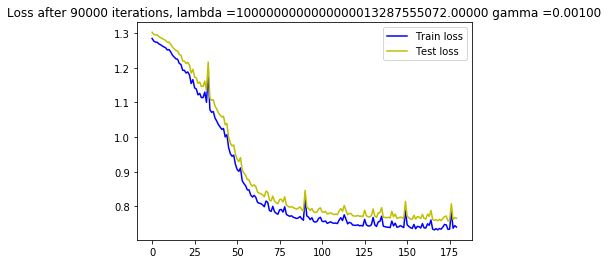

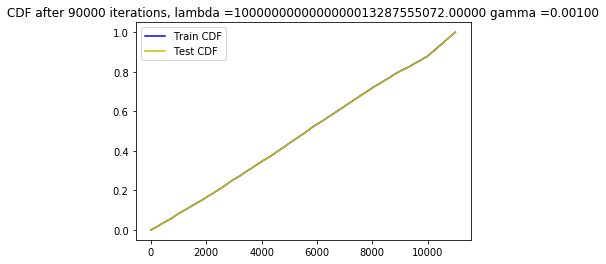

 19%|█▉        | 90009/473047 [1:17:20<33:29:03,  3.18it/s]

New score:  0.69003904
Train score:  0.87047976
Test score:  0.85102713


 20%|██        | 94997/473047 [1:20:02<1:18:43, 80.04it/s] 

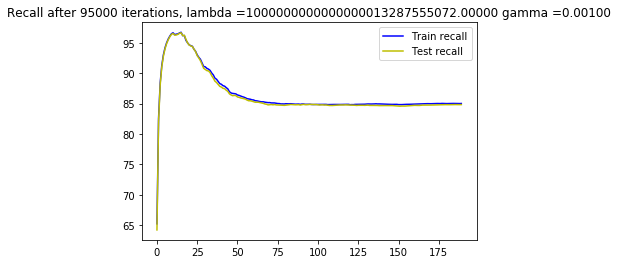

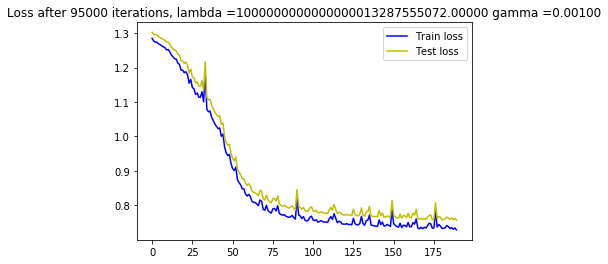

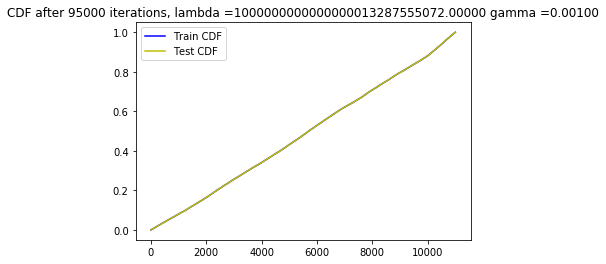

 20%|██        | 95015/473047 [1:20:14<29:31:17,  3.56it/s]

New score:  0.6014168
Train score:  0.78168577
Test score:  0.8688675


 21%|██        | 99993/473047 [1:22:56<1:17:11, 80.54it/s]  

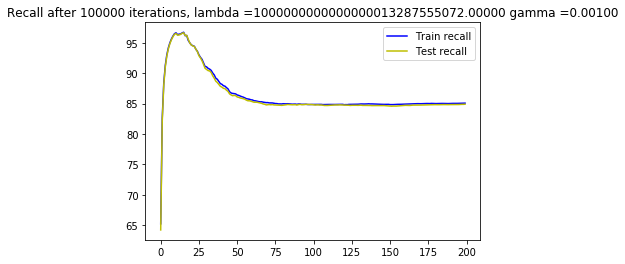

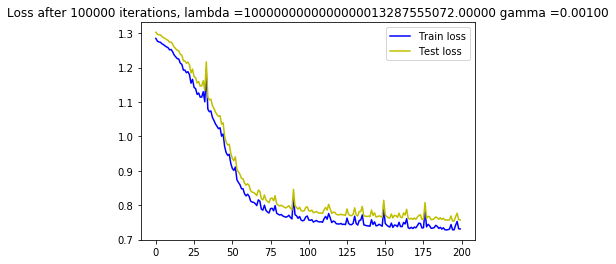

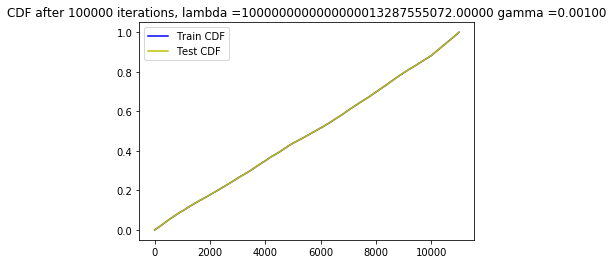

 21%|██        | 100010/473047 [1:23:08<29:07:30,  3.56it/s]

New score:  0.7073403
Train score:  0.81164026
Test score:  0.9430574


 22%|██▏       | 104992/473047 [1:25:50<1:16:08, 80.56it/s] 

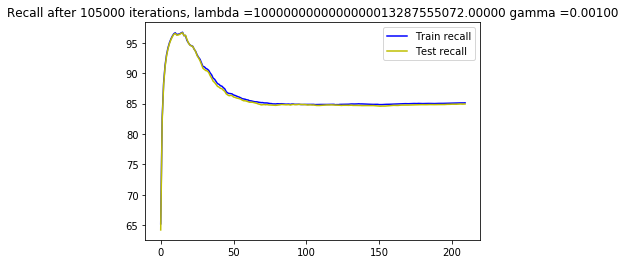

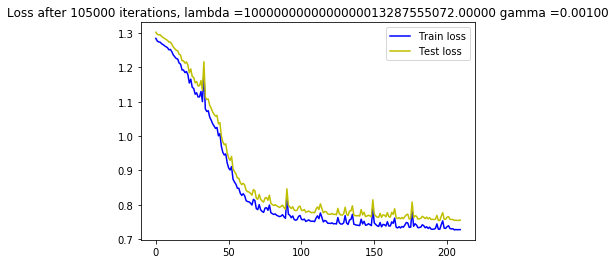

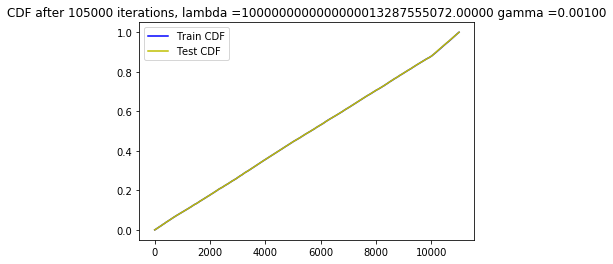

 22%|██▏       | 105009/473047 [1:26:02<28:45:33,  3.55it/s]

New score:  0.5613805
Train score:  0.7692304
Test score:  0.8911991


 23%|██▎       | 109995/473047 [1:28:44<1:15:09, 80.51it/s]  

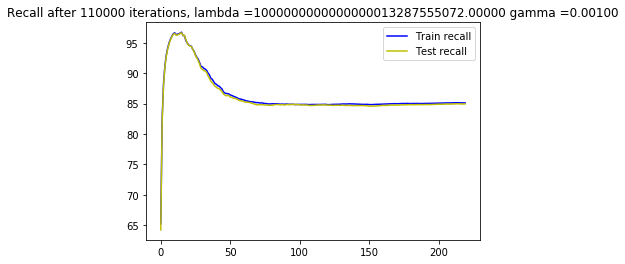

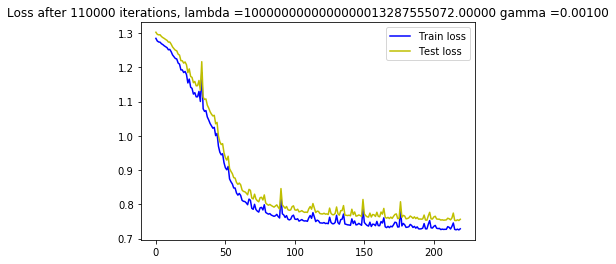

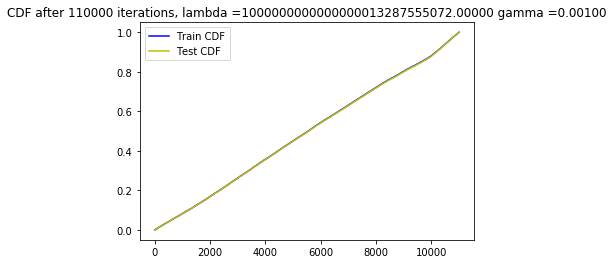

 23%|██▎       | 110013/473047 [1:28:56<28:20:34,  3.56it/s]

New score:  0.7247396
Train score:  0.7324355
Test score:  0.8185028


 24%|██▍       | 114993/473047 [1:31:37<1:14:15, 80.37it/s] 

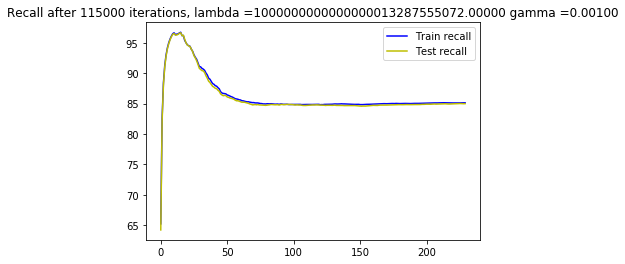

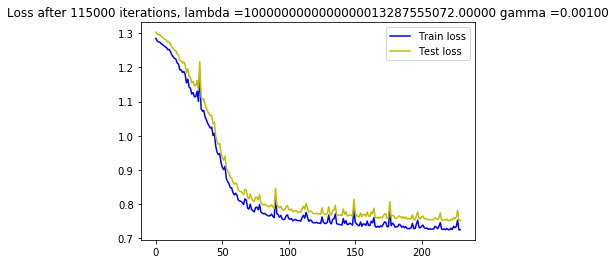

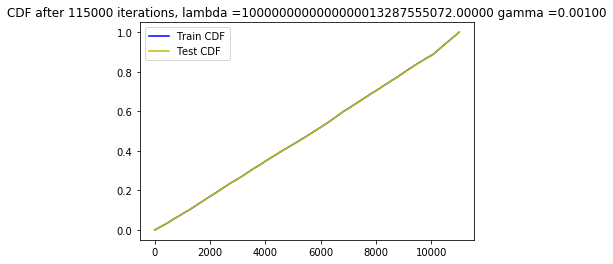

 24%|██▍       | 115011/473047 [1:31:49<27:53:50,  3.57it/s]

New score:  0.5638467
Train score:  0.76872456
Test score:  0.8566082


 25%|██▌       | 119998/473047 [1:34:32<1:13:14, 80.33it/s] 

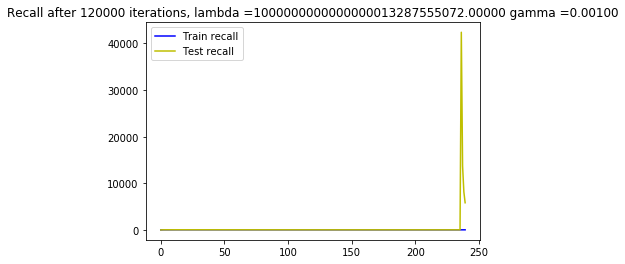

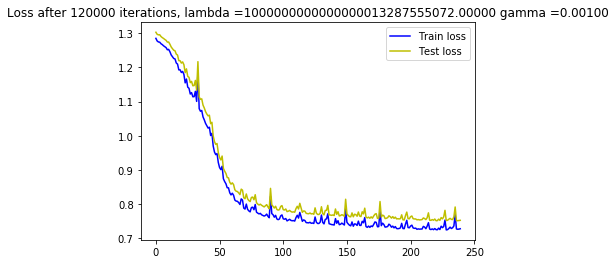

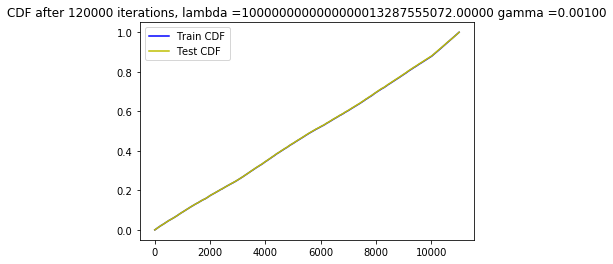

 25%|██▌       | 120015/473047 [1:34:43<27:38:32,  3.55it/s]

New score:  0.48842135
Train score:  0.8210883
Test score:  0.848745


 26%|██▋       | 124994/473047 [1:37:26<1:11:41, 80.92it/s] 

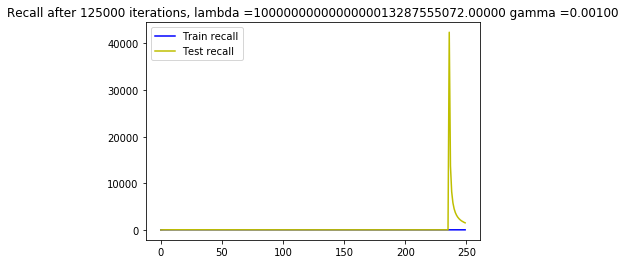

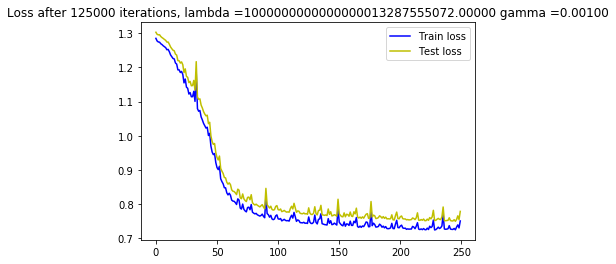

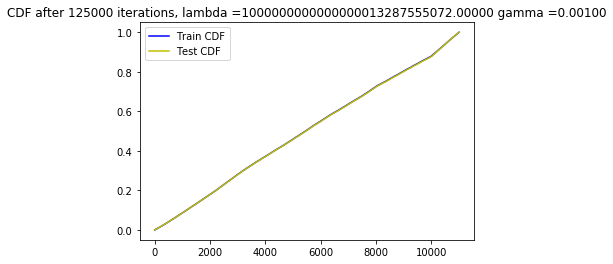

 26%|██▋       | 125011/473047 [1:37:37<27:09:42,  3.56it/s]

New score:  0.55271965
Train score:  0.78916866
Test score:  0.7786953


 27%|██▋       | 129998/473047 [1:40:30<1:11:58, 79.43it/s] 

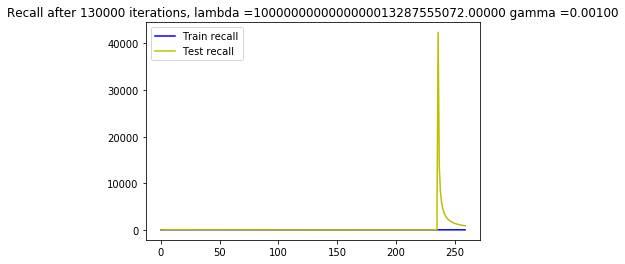

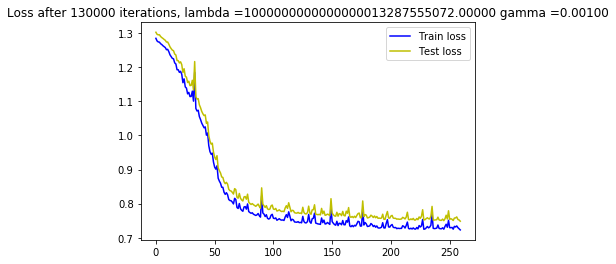

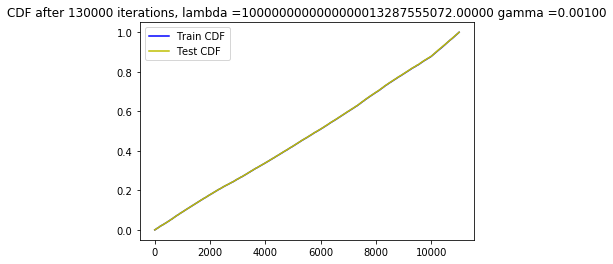

 27%|██▋       | 130009/473047 [1:40:31<78:30:26,  1.21it/s] 

New score:  0.5636698
Train score:  0.9329441
Test score:  0.9132435


 29%|██▊       | 134993/473047 [1:43:14<1:10:36, 79.79it/s] 

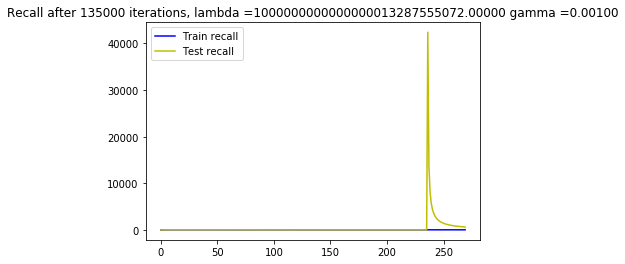

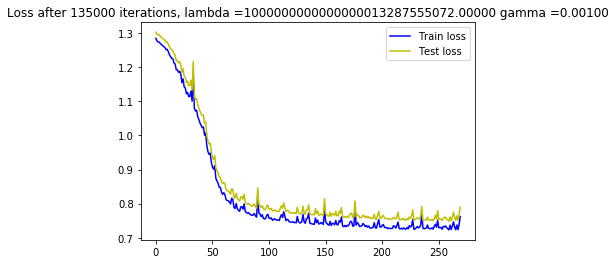

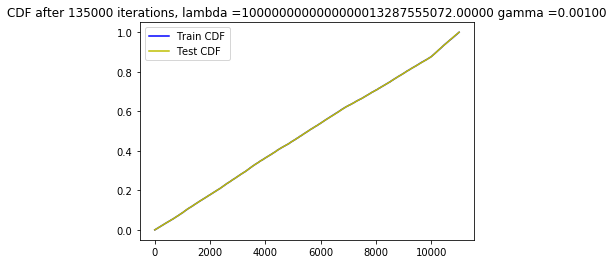

 29%|██▊       | 135009/473047 [1:43:26<29:36:32,  3.17it/s]

New score:  0.66733617
Train score:  0.6936586
Test score:  0.7998437


 30%|██▉       | 140000/473047 [1:46:20<1:08:53, 80.57it/s] 

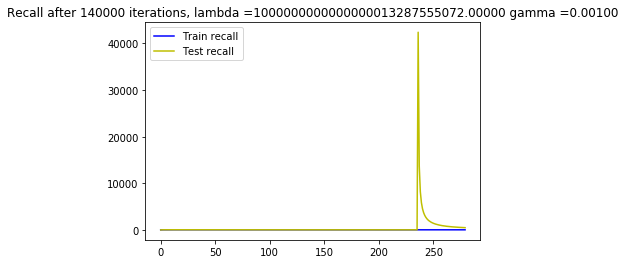

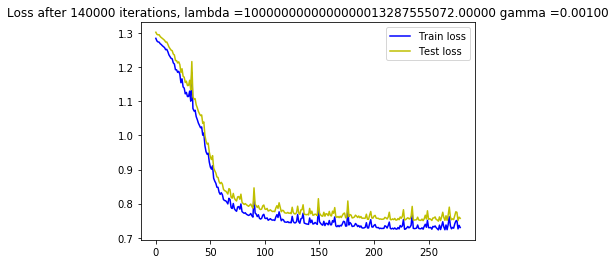

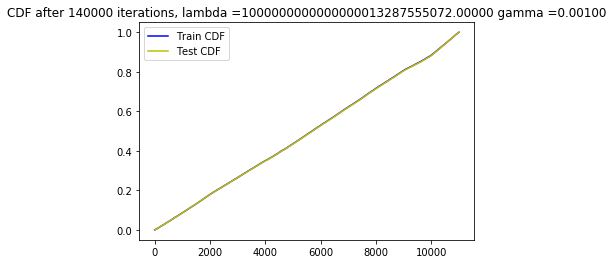

 30%|██▉       | 140009/473047 [1:46:21<224:45:37,  2.43s/it]

New score:  0.5653319
Train score:  0.7816662
Test score:  0.84139216


 31%|███       | 144999/473047 [1:49:03<1:09:34, 78.58it/s]  

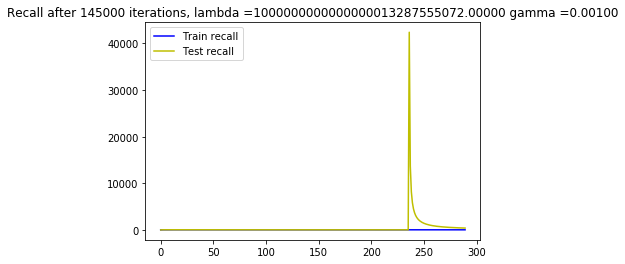

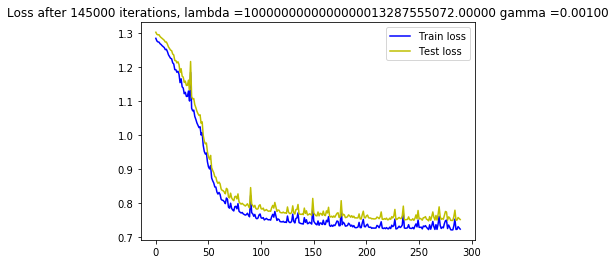

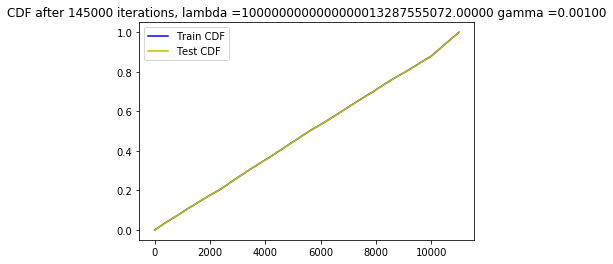

 31%|███       | 145015/473047 [1:49:15<29:06:19,  3.13it/s]

New score:  0.45047712
Train score:  0.82818806
Test score:  0.8647127


 32%|███▏      | 149992/473047 [1:52:00<1:08:16, 78.87it/s]  

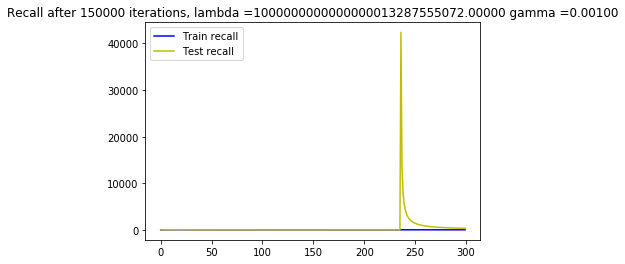

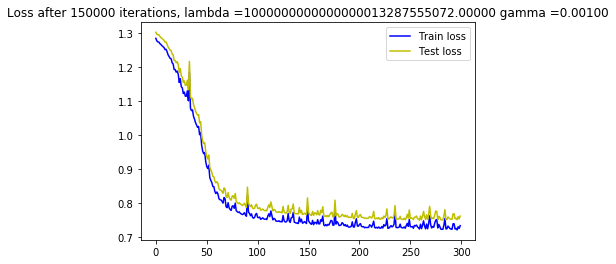

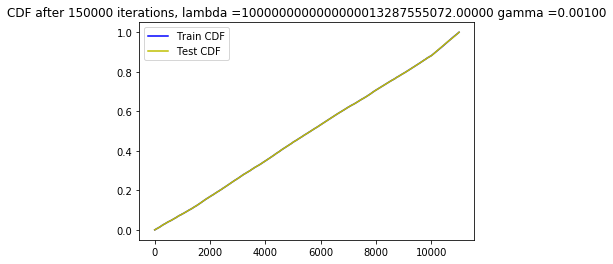

 32%|███▏      | 150009/473047 [1:52:12<25:35:14,  3.51it/s]

New score:  0.5788636
Train score:  0.9006426
Test score:  0.88447344


 33%|███▎      | 154997/473047 [1:54:57<1:07:04, 79.03it/s] 

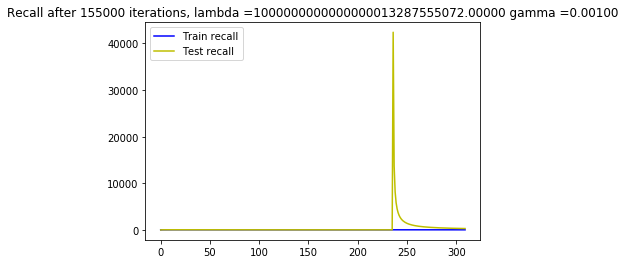

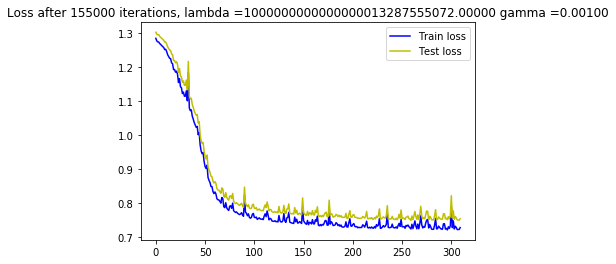

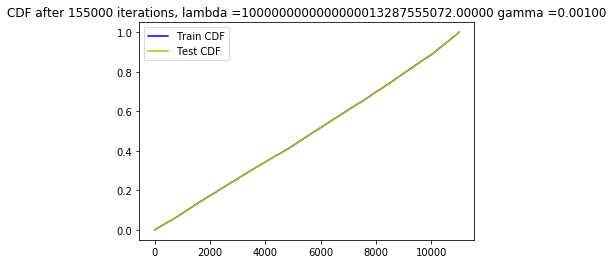

 33%|███▎      | 155013/473047 [1:55:09<28:19:49,  3.12it/s]

New score:  0.72746015
Train score:  0.8529111
Test score:  0.8735982


 34%|███▎      | 158494/473047 [1:57:01<1:06:18, 79.06it/s] 

KeyboardInterrupt: 

In [12]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])